### Imports and Hyperparameters

In [1]:
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

%matplotlib inline

In [2]:
import config

### A visualization helper function

In [3]:
def display_image(image, boxes=None, box_color=[0, 0, 255], box_thickness=3, ax=None):
    image = np.array(image)
    
    if boxes is not None:
        boxes = np.array(boxes)[..., :5]
        boxes = [ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=config.CLASSES[int(label)])
                 for x1, y1, x2, y2, label in boxes]
        boxes = ia.BoundingBoxesOnImage(boxes, shape=image.shape)
        image = boxes.draw_on_image(image, color=box_color,
                                    size=box_thickness)
    
    if ax is None:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')

### Load and visualize some image

Visualize some REAL images with their boxes for sanity checking 

Loaded 7144 image samples
Loaded 1000 image samples
(7144,)
(7144, None, 5)


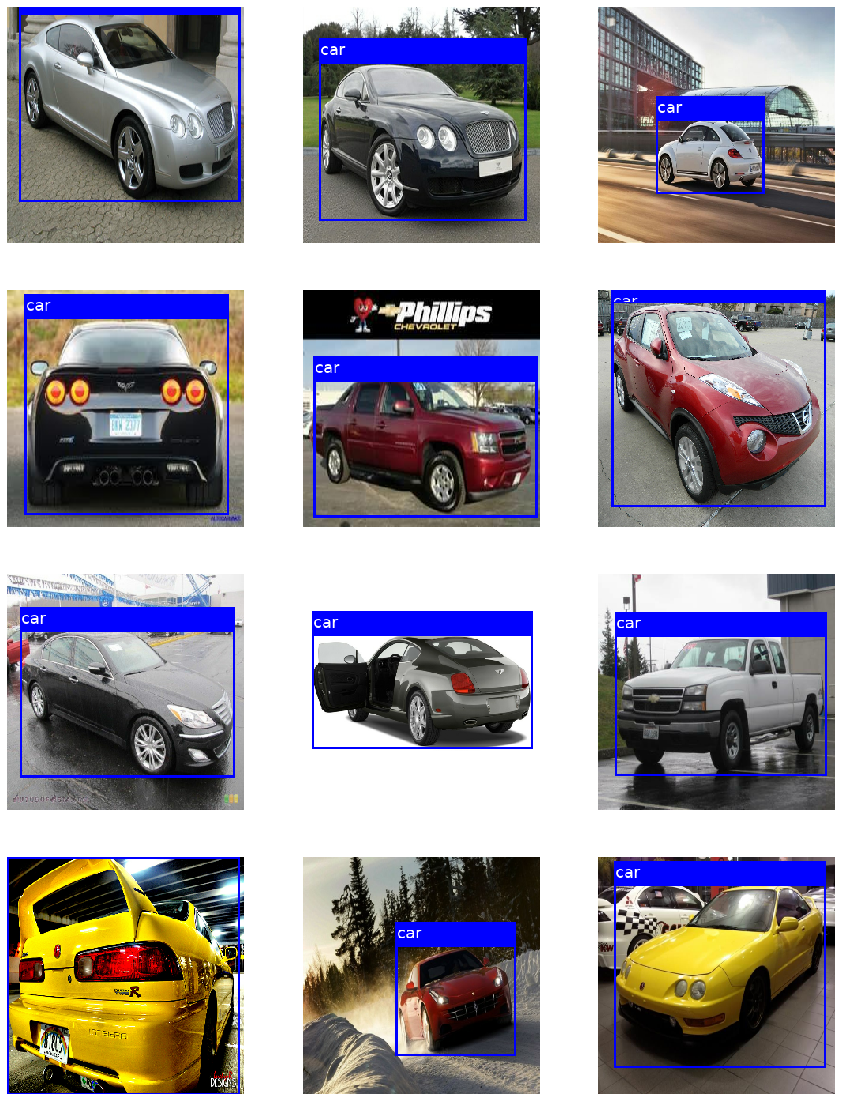

In [4]:
from cars_loader import load_cars, build_dataset

train_image_paths, train_bnd_boxes = load_cars(split='train')
valid_image_paths, valid_bnd_boxes = load_cars(split='valid')
data = build_dataset(train_image_paths, train_bnd_boxes,
                    image_size=config.IMAGE_SIZE)

num_display = 12
num_cols = 3
num_rows = (num_display+1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(data)

for idx in range(num_display):
    x, y = next(data_iter)
    display_image(x, y.to_tensor(), ax=fig.axes[idx])
    
plt.show()

## MobileNet

### Instantiate the model

In [5]:
from ssd_utils.networks.ssd_mobilenet import SSDMobileNet

model = SSDMobileNet(num_classes=len(config.CLASSES), name='ssd_mobilenet')

### Create the data pipelines

In [6]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 2430, 6)
(16, 300, 300, 3) (16, None, None)


### Train the model

In [7]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('baseline_mobilenet.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 18.1651

Calculating Average Precision...: 29it [00:00, 284.15it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 402.17it/s]


25/25 [==============================] - 28s 1s/step - loss: 18.1651 - val_meanAP: 0.0450
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 4.6674

Calculating Average Precision...: 26it [00:00, 251.35it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 290.21it/s]


25/25 [==============================] - 36s 1s/step - loss: 4.6674 - val_meanAP: 0.0817
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 3.3725

Calculating Average Precision...: 20it [00:00, 197.11it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:05, 197.57it/s]


25/25 [==============================] - 39s 2s/step - loss: 3.3725 - val_meanAP: 0.1692
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 2.5054

Calculating Average Precision...: 16it [00:00, 155.28it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:07, 142.43it/s]


25/25 [==============================] - 44s 2s/step - loss: 2.5054 - val_meanAP: 0.2334
Epoch 5/20
25/25 [==============================] - ETA: 0s - loss: 1.9285

Calculating Average Precision...: 14it [00:00, 136.38it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:08, 119.60it/s]


25/25 [==============================] - 59s 2s/step - loss: 1.9285 - val_meanAP: 0.3240
Epoch 6/20
25/25 [==============================] - ETA: 0s - loss: 1.5780

Calculating Average Precision...: 13it [00:00, 127.04it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:08, 114.53it/s]


25/25 [==============================] - 51s 2s/step - loss: 1.5780 - val_meanAP: 0.4004
Epoch 7/20
25/25 [==============================] - ETA: 0s - loss: 1.3204

Calculating Average Precision...: 15it [00:00, 142.52it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:08, 116.14it/s]


25/25 [==============================] - 53s 2s/step - loss: 1.3204 - val_meanAP: 0.5063
Epoch 8/20
25/25 [==============================] - ETA: 0s - loss: 1.0940

Calculating Average Precision...: 15it [00:00, 144.38it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:07, 136.86it/s]


25/25 [==============================] - 46s 2s/step - loss: 1.0940 - val_meanAP: 0.6087
Epoch 9/20
25/25 [==============================] - ETA: 0s - loss: 1.0140

Calculating Average Precision...: 14it [00:00, 138.11it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:07, 141.02it/s]


25/25 [==============================] - 48s 2s/step - loss: 1.0140 - val_meanAP: 0.7062
Epoch 10/20
25/25 [==============================] - ETA: 0s - loss: 0.8614

Calculating Average Precision...: 22it [00:00, 216.02it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:05, 183.55it/s]


25/25 [==============================] - 55s 2s/step - loss: 0.8614 - val_meanAP: 0.7681
Epoch 11/20
25/25 [==============================] - ETA: 0s - loss: 0.8182

Calculating Average Precision...: 24it [00:00, 234.48it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:04, 204.52it/s]


25/25 [==============================] - 55s 2s/step - loss: 0.8182 - val_meanAP: 0.8154
Epoch 12/20
25/25 [==============================] - ETA: 0s - loss: 0.7836

Calculating Average Precision...: 24it [00:00, 234.78it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:04, 207.37it/s]


25/25 [==============================] - 42s 2s/step - loss: 0.7836 - val_meanAP: 0.8739
Epoch 13/20
25/25 [==============================] - ETA: 0s - loss: 0.6668

Calculating Average Precision...: 22it [00:00, 218.32it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:04, 206.50it/s]


25/25 [==============================] - 45s 2s/step - loss: 0.6668 - val_meanAP: 0.9121
Epoch 14/20
25/25 [==============================] - ETA: 0s - loss: 0.6233

Calculating Average Precision...: 31it [00:00, 303.95it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 253.01it/s]


25/25 [==============================] - 40s 2s/step - loss: 0.6233 - val_meanAP: 0.9328
Epoch 15/20
25/25 [==============================] - ETA: 0s - loss: 0.6164

Calculating Average Precision...: 36it [00:00, 342.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 308.78it/s]


25/25 [==============================] - 37s 1s/step - loss: 0.6164 - val_meanAP: 0.9616
Epoch 16/20
25/25 [==============================] - ETA: 0s - loss: 0.5414

Calculating Average Precision...: 39it [00:00, 385.73it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 381.56it/s]


25/25 [==============================] - 35s 1s/step - loss: 0.5414 - val_meanAP: 0.9666
Epoch 17/20
25/25 [==============================] - ETA: 0s - loss: 0.5251

Calculating Average Precision...: 43it [00:00, 422.69it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 408.71it/s]


25/25 [==============================] - 34s 1s/step - loss: 0.5251 - val_meanAP: 0.9772
Epoch 18/20
25/25 [==============================] - ETA: 0s - loss: 0.4993

Calculating Average Precision...: 38it [00:00, 379.59it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 424.13it/s]


25/25 [==============================] - 33s 1s/step - loss: 0.4993 - val_meanAP: 0.9818
Epoch 19/20
25/25 [==============================] - ETA: 0s - loss: 0.4848

Calculating Average Precision...: 47it [00:00, 467.07it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 477.47it/s]


25/25 [==============================] - 36s 1s/step - loss: 0.4848 - val_meanAP: 0.9847
Epoch 20/20
25/25 [==============================] - ETA: 0s - loss: 0.4591

Calculating Average Precision...: 52it [00:00, 509.23it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 524.04it/s]


25/25 [==============================] - 36s 1s/step - loss: 0.4591 - val_meanAP: 0.9853


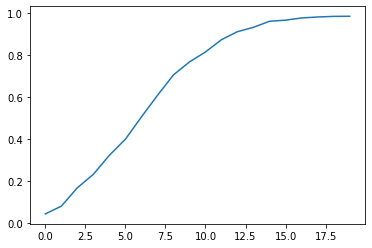

In [9]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 53it [00:00, 522.59it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 515.01it/s]


Validation meanAP: tf.Tensor(0.9853447534811874, shape=(), dtype=float64)


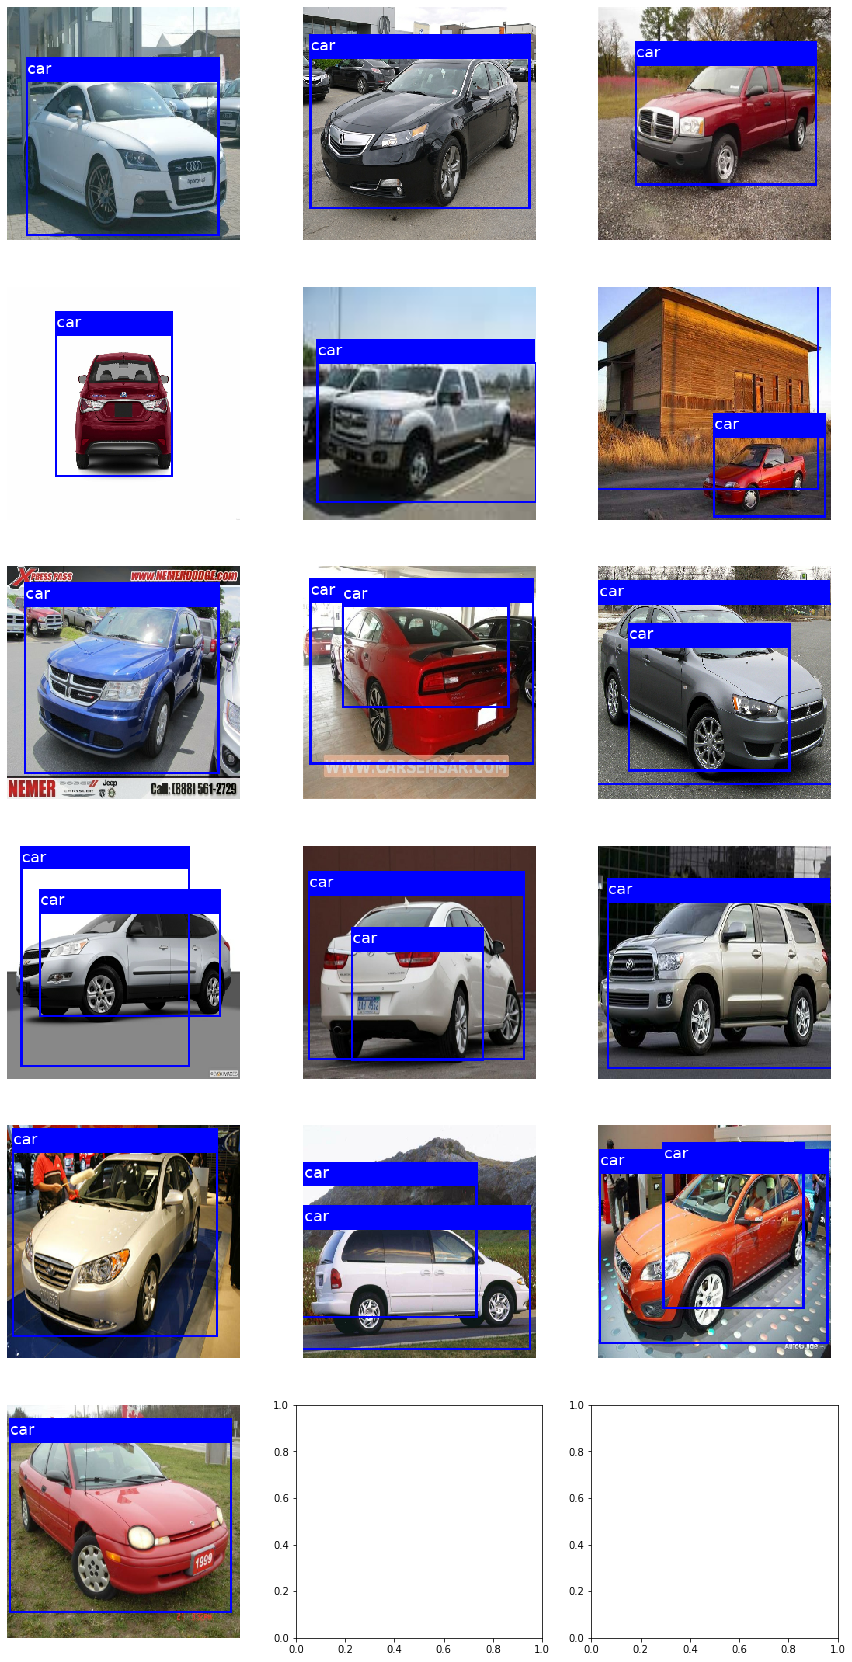

In [10]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'baseline_mobilenet.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

## ResNet50

### Instantiate the model

In [11]:
from ssd_utils.networks.ssd_resnet50 import SSDResNet50

model = SSDResNet50(num_classes=len(config.CLASSES), name='ssd_resnet50')

### Create the data pipelines

In [12]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 4149, 6)
(16, 300, 300, 3) (16, None, None)


### Train the model

In [13]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('baseline_resnet50.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 10.0582

Calculating Average Precision...: 15it [00:00, 140.90it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:06, 150.51it/s]


25/25 [==============================] - 53s 2s/step - loss: 10.0582 - val_meanAP: 0.7172
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 1.6296

Calculating Average Precision...: 21it [00:00, 198.34it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:04, 216.31it/s]


25/25 [==============================] - 48s 2s/step - loss: 1.6296 - val_meanAP: 0.8949
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.9318

Calculating Average Precision...: 25it [00:00, 245.02it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 262.03it/s]


25/25 [==============================] - 51s 2s/step - loss: 0.9318 - val_meanAP: 0.9361
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.7434

Calculating Average Precision...: 34it [00:00, 336.55it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 307.06it/s]


25/25 [==============================] - 48s 2s/step - loss: 0.7434 - val_meanAP: 0.9784
Epoch 5/20
25/25 [==============================] - ETA: 0s - loss: 0.5707

Calculating Average Precision...: 35it [00:00, 344.25it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 326.99it/s]


25/25 [==============================] - 48s 2s/step - loss: 0.5707 - val_meanAP: 0.9878
Epoch 6/20
25/25 [==============================] - ETA: 0s - loss: 0.4871

Calculating Average Precision...: 40it [00:00, 399.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 436.54it/s]


25/25 [==============================] - 47s 2s/step - loss: 0.4871 - val_meanAP: 0.9942
Epoch 7/20
25/25 [==============================] - ETA: 0s - loss: 0.3957

Calculating Average Precision...: 57it [00:00, 569.95it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 483.14it/s]


25/25 [==============================] - 48s 2s/step - loss: 0.3957 - val_meanAP: 0.9976
Epoch 8/20
25/25 [==============================] - ETA: 0s - loss: 0.3675

Calculating Average Precision...: 61it [00:00, 605.39it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 578.38it/s]

25/25 [==============================] - 41s 2s/step - loss: 0.3675 - val_meanAP: 0.9947


Epoch 9/20
25/25 [==============================] - ETA: 0s - loss: 0.3488

Calculating Average Precision...: 54it [00:00, 531.92it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 536.43it/s]


25/25 [==============================] - 47s 2s/step - loss: 0.3488 - val_meanAP: 0.9978
Epoch 10/20
25/25 [==============================] - ETA: 0s - loss: 0.3674

Calculating Average Precision...: 78it [00:00, 779.49it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 657.68it/s]


25/25 [==============================] - 48s 2s/step - loss: 0.3674 - val_meanAP: 0.9984
Epoch 11/20
25/25 [==============================] - ETA: 0s - loss: 0.3351

Calculating Average Precision...: 62it [00:00, 619.71it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 540.52it/s]


25/25 [==============================] - 48s 2s/step - loss: 0.3351 - val_meanAP: 0.9995
Epoch 12/20
25/25 [==============================] - ETA: 0s - loss: 0.3196

Calculating Average Precision...: 71it [00:00, 703.76it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 760.47it/s]


25/25 [==============================] - 47s 2s/step - loss: 0.3196 - val_meanAP: 0.9999
Epoch 13/20
25/25 [==============================] - ETA: 0s - loss: 0.2536

Calculating Average Precision...: 73it [00:00, 726.97it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 742.69it/s]

25/25 [==============================] - 40s 2s/step - loss: 0.2536 - val_meanAP: 0.9989


Epoch 14/20
25/25 [==============================] - ETA: 0s - loss: 0.2634

Calculating Average Precision...: 77it [00:00, 763.53it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 771.10it/s]

25/25 [==============================] - 40s 2s/step - loss: 0.2634 - val_meanAP: 0.9998


Epoch 15/20
25/25 [==============================] - ETA: 0s - loss: 0.2655

Calculating Average Precision...: 76it [00:00, 759.97it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 800.75it/s]


25/25 [==============================] - 39s 2s/step - loss: 0.2655 - val_meanAP: 0.9999
Epoch 16/20
25/25 [==============================] - ETA: 0s - loss: 0.2651

Calculating Average Precision...: 71it [00:00, 702.31it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 761.50it/s]


25/25 [==============================] - 40s 2s/step - loss: 0.2651 - val_meanAP: 1.0000
Epoch 17/20
25/25 [==============================] - ETA: 0s - loss: 0.2531

Calculating Average Precision...: 68it [00:00, 676.39it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 807.15it/s]


25/25 [==============================] - 39s 2s/step - loss: 0.2531 - val_meanAP: 1.0000
Epoch 18/20
25/25 [==============================] - ETA: 0s - loss: 0.2648

Calculating Average Precision...: 74it [00:00, 731.57it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 838.45it/s]

25/25 [==============================] - 37s 1s/step - loss: 0.2648 - val_meanAP: 1.0000


Epoch 19/20
25/25 [==============================] - ETA: 0s - loss: 0.2538

Calculating Average Precision...: 71it [00:00, 691.47it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 734.10it/s]

25/25 [==============================] - 37s 1s/step - loss: 0.2538 - val_meanAP: 0.9998


Epoch 20/20
25/25 [==============================] - ETA: 0s - loss: 0.2385

Calculating Average Precision...: 71it [00:00, 695.31it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 784.97it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.2385 - val_meanAP: 0.9999


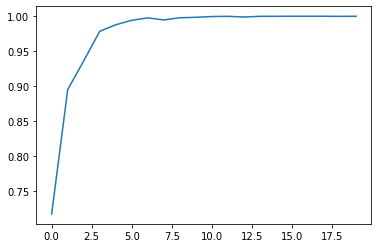

In [14]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 77it [00:00, 766.67it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 774.53it/s]


Validation meanAP: tf.Tensor(0.9999670592746734, shape=(), dtype=float64)


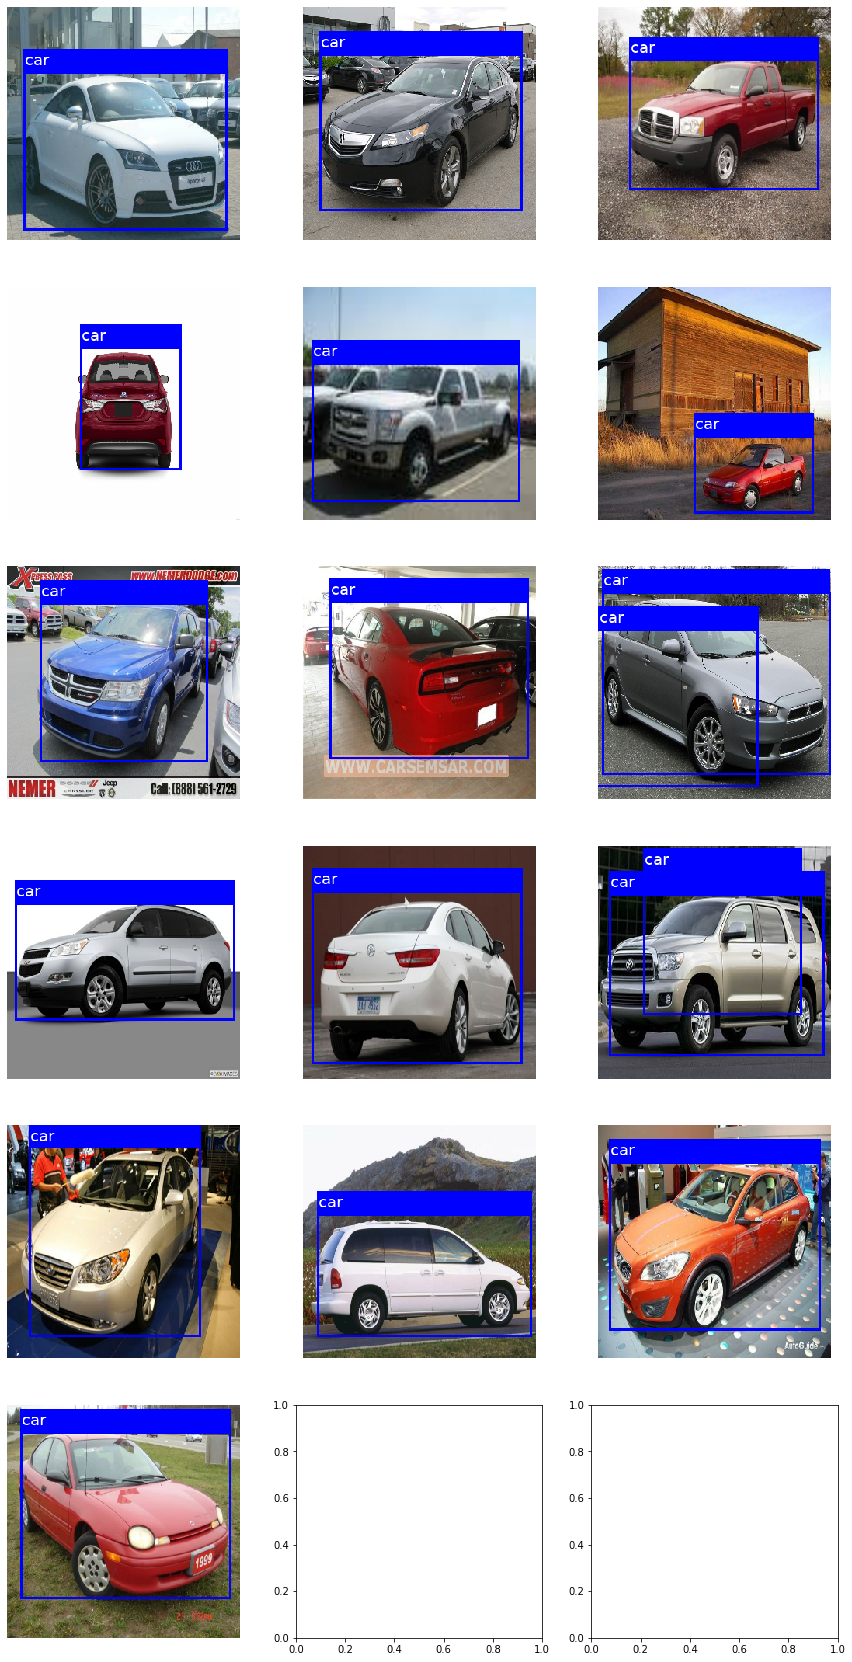

In [15]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'baseline_resnet50.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()